In [1]:
# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS

In [3]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


Sentence_1 = 'Life well spent is life good'
Sentence_2 = 'Life is an art and it is good so far'
Sentence_3 = 'Life well spent is life bad'
    
jaccard(Sentence_1,Sentence_2)
jaccard(Sentence_1,Sentence_3)

0.6666666666666666

## 1) Load Data

In [4]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

In [5]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (27486, 4)
Training Set Memory Usage = 0.84 MB
Test Set Shape = (3535, 3)
Test Set Memory Usage = 0.08 MB


In [6]:
df_train.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [7]:
df_test.head()

,textID,text,sentiment
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...,positive
1,fd1db57dc0,i'm done.haha. HOUSE MD marathon ulet,positive
2,2524332d66,I'm concerned for that family,positive
3,0fb19285b2,HEY GUYS IT'S WORKING NO NEED TO WORRY. i have...,positive
4,e6c9e5e3ab,26th February,neutral


## 2) EDA

In [8]:
df_train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [9]:
df_train[df_train["text"].isnull()].head()

,textID,text,selected_text,sentiment
13133,fdb77c3752,NaN,NaN,neutral


In [10]:
df_train= df_train.dropna()

In [11]:
df_train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7786
Name: sentiment, dtype: int64

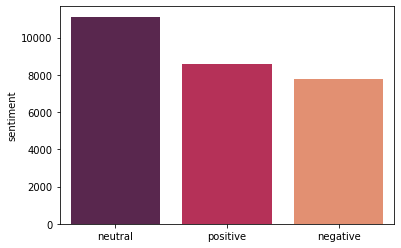

In [12]:
sns.barplot(df_train['sentiment'].value_counts().index,df_train['sentiment'].value_counts(),palette='rocket')

In [13]:
df_test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [14]:
df_test['sentiment'].value_counts()

neutral     1430
positive    1104
negative    1001
Name: sentiment, dtype: int64

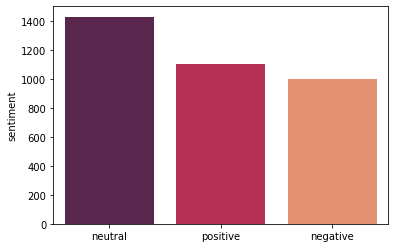

In [15]:
sns.barplot(df_test['sentiment'].value_counts().index,df_test['sentiment'].value_counts(),palette='rocket')

In [44]:
df_train['text_length']=[ len(x) for x in df_train['text']]
df_train['text_word_count']= df_train['text'].apply(lambda x: len(str(x).split()))


df_test['text_length']=[ len(x) for x in df_test['text']]
df_test['text_word_count']= df_test['text'].apply(lambda x: len(str(x).split()))

df_train.head()

,textID,text,selected_text,sentiment,text_length,text_word_count
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,132,28
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,46,9
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,69,9
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,43,9
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,39,6


In [17]:
df_train_positive= df_train[df_train["sentiment"]=="positive"]
df_train_negative= df_train[df_train["sentiment"]=="negative"]
df_train_neutral= df_train[df_train["sentiment"]=="neutral"]

In [18]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    comment_words = ''
    for val in data:
        val = str(val) 
        tokens = val.split() 
      
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
     
        for words in tokens: 
            comment_words = comment_words + words + ' '
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
    return wordcloud
    


In [19]:
wordcloud_positive= show_wordcloud(df_train_positive["selected_text"])
wordcloud_negative= show_wordcloud(df_train_negative["selected_text"])
wordcloud_neutral= show_wordcloud(df_train_neutral["selected_text"])


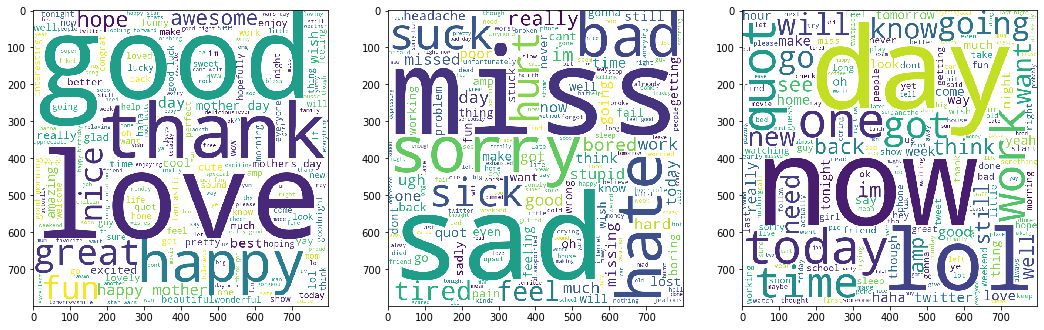

In [20]:
f = plt.figure(figsize = (18, 18))
f.add_subplot(1,3, 1)
plt.imshow(wordcloud_positive)
f.add_subplot(1,3, 2)
plt.imshow(wordcloud_negative)
f.add_subplot(1,3, 3)
plt.imshow(wordcloud_neutral)
plt.show(block=True)

[Text(0, 0.5, 'count'),
 Text(0.5, 0, 'text_length_count'),
 Text(0.5, 1.0, 'text_length for test data')]

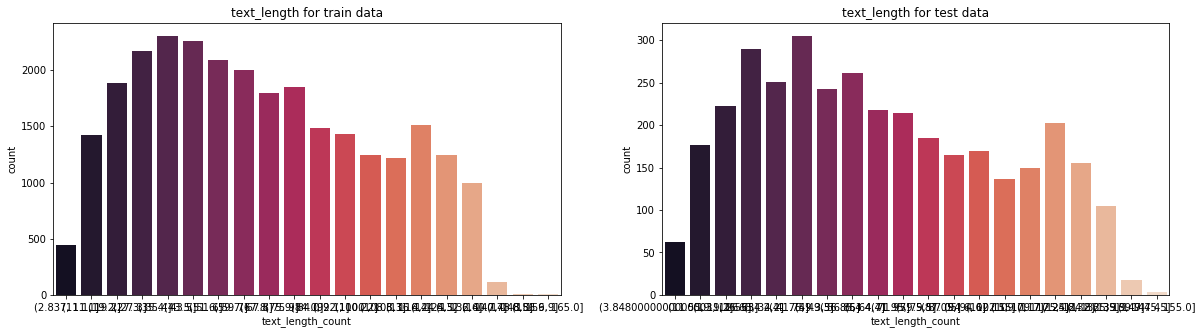

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax_train=sns.barplot(df_train['text_length'].value_counts(bins=20,sort=False).index,
            df_train['text_length'].value_counts(bins=20,sort=False),palette='rocket', ax=ax1)
ax_train.set(xlabel='text_length_count', ylabel='count', title='text_length for train data')


ax_test=sns.barplot(df_test['text_length'].value_counts(bins=20,sort=False).index,
            df_test['text_length'].value_counts(bins=20,sort=False),palette='rocket', ax=ax2)
ax_test.set(xlabel='text_length_count', ylabel='count', title='text_length for test data')

[Text(0, 0.5, 'count'),
 Text(0.5, 0, 'text_word_count'),
 Text(0.5, 1.0, 'word_count for test data')]

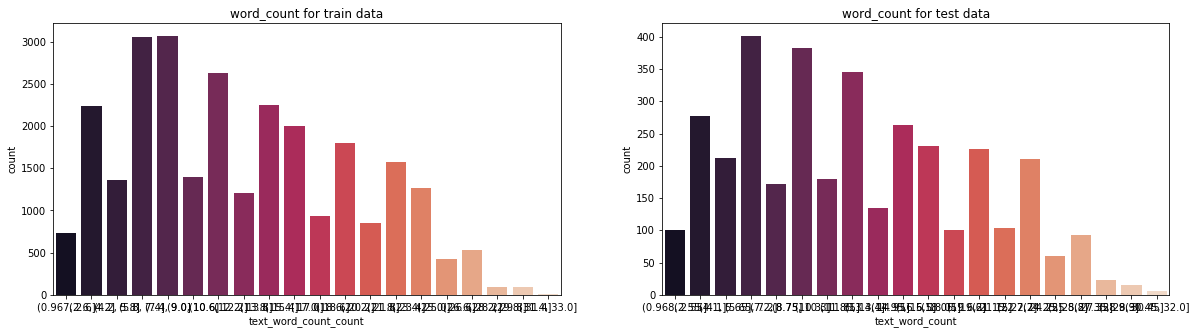

In [22]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax_train=sns.barplot(df_train['text_word_count'].value_counts(bins=20,sort=False).index,
            df_train['text_word_count'].value_counts(bins=20,sort=False),palette='rocket', ax=ax1)
ax_train.set(xlabel='text_word_count_count', ylabel='count', title='word_count for train data')


ax_test=sns.barplot(df_test['text_word_count'].value_counts(bins=20,sort=False).index,
            df_test['text_word_count'].value_counts(bins=20,sort=False),palette='rocket', ax=ax2)
ax_test.set(xlabel='text_word_count', ylabel='count', title='word_count for test data')



## 3) BERT

In [23]:
df_mislabeled = df_train.groupby('textID')['textID'].value_counts()

print(df_train.groupby('textID')['textID'].value_counts())


###NO duplicates

textID      textID    
0003e2a304  0003e2a304    1
0004c81c93  0004c81c93    1
0009df8104  0009df8104    1
000a596b74  000a596b74    1
000c2fc4a9  000c2fc4a9    1
                         ..
ffe6fab196  ffe6fab196    1
fff17f71fe  fff17f71fe    1
fff190b4af  fff190b4af    1
fff44ae9f9  fff44ae9f9    1
fff983ef6b  fff983ef6b    1
Name: textID, Length: 27485, dtype: int64


In [24]:
import spacy
import torch
# Need to load the large model to get the vectors
nlp = spacy.load('en_core_web_lg')


In [25]:
text = "These vectors can be used as features for machine learning models."
vectors = np.array([token.vector for token in  nlp(text)])
vectors.shape


(12, 300)

In [26]:
import transformers as ppb # pytorch transformers

In [27]:
batch_size=32
step= int(df_train['text'].shape[0]/batch_size) +1


In [40]:
# For DistilBERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [48]:
df_train.head()

,textID,text,selected_text,sentiment,text_length,text_word_count
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,132,28
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,46,9
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,69,9
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,43,9
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,39,6


Determining MAX_LEN

In [67]:

max_len = 0

# For every sentence...
for sent in df_train['text']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  110


In [70]:
MAX_LEN = 128

In [98]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in df_train['text']:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', df_train['text'][0])
print('Token IDs:', input_ids[0])
print('shape:', input_ids[0].shape)

Original:  Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun.  I had other plans for my morning
Token IDs: tensor([  101,  2985,  1996,  2972,  2851,  1999,  1037,  3116,  1059,  1013,
         1037, 21431,  1010,  1998,  2026,  5795,  2001,  2025,  3407,  1059,
         1013,  2068,  1012,  7167,  1997,  4569,  1012,  1045,  2018,  2060,
         3488,  2005,  2026,  2851,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,  

Divide up our training set to use 90% for training and 10% for validation.

In [99]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

shape: torch.Size([128])


In [30]:
tokenized = df_train['text'][:step].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [31]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [33]:
attention_mask = np.where(padded != 0, 1, 0)

In [34]:
input_ids = torch.tensor(padded).to(torch.int64) 
attention_mask = torch.tensor(attention_mask)


In [35]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [39]:
last_hidden_states

(tensor([[[-0.1292, -0.3192,  0.0060,  ..., -0.1241,  0.3683,  0.2709],
          [ 0.1142, -0.1084, -0.0118,  ..., -0.1216,  0.6209,  0.1342],
          [-0.5325, -0.5733,  0.1683,  ...,  0.0123,  0.6626, -0.1660],
          ...,
          [-0.0207, -0.0456, -0.0229,  ...,  0.0417, -0.1310, -0.0582],
          [ 0.1008, -0.1156,  0.2072,  ..., -0.0069, -0.0200,  0.1059],
          [-0.0605, -0.1697,  0.1103,  ...,  0.0408, -0.0548, -0.0244]],
 
         [[-0.1173,  0.0011,  0.1320,  ..., -0.1122,  0.1611,  0.2539],
          [ 0.4419,  0.4539,  0.4824,  ...,  0.0945,  0.5938, -0.0299],
          [-0.0755,  0.2585,  0.4407,  ..., -0.1096,  0.4413,  0.3370],
          ...,
          [-0.1795,  0.1588,  0.1106,  ...,  0.2402, -0.1273, -0.0342],
          [ 0.0247,  0.0998, -0.0723,  ...,  0.1440, -0.0720, -0.0439],
          [ 0.3070,  0.1642,  0.0662,  ...,  0.2750,  0.0304, -0.2672]],
 
         [[-0.0681, -0.2058,  0.0127,  ..., -0.0754,  0.3758,  0.2807],
          [ 0.2150,  0.3272,